# Example 1: Function Fitting

In this example, we will cover how to leverage grid refinement to maximimze KANs' ability to fit functions

intialize model and create dataset

In [6]:
from kan import *


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# initialize KAN with G=3
#model = KAN(width=[2,[2,1],1], grid=100, k=3, device=device)
model = KAN(width=[2,[2,1],1], grid=3, k=3, device=device)

data_range_theta = torch.linspace(-0.8, 0.8, steps = 1001)[:,None]
data_range_theta_dot = torch.linspace(-1.0, 1.0, steps = 1001)[:,None]
data_range = torch.cat((data_range_theta, data_range_theta_dot), dim=1).to(device)

# create dataset
a = 0.25
b = 0.5
f = lambda x: 1 - ((x[:,[0]]**2)/a**2) - ((x[:,[1]]**2)/b**2) - (x[:,[0]] * x[:,[1]])/(a*b)
dataset = create_dataset(f, n_var=2, ranges=data_range, device=device)

cpu
checkpoint directory created: ./model
saving model version 0.0


Train KAN (grid=3)

In [101]:
model.fit(dataset, opt="Adam", steps=20);

| train_loss: 1.53e+00 | test_loss: 1.44e+00 | reg: 3.59e+01 | : 100%|█| 20/20 [00:01<00:00, 12.68it


saving model version 0.1


The loss plateaus. we want a more fine-grained KAN!

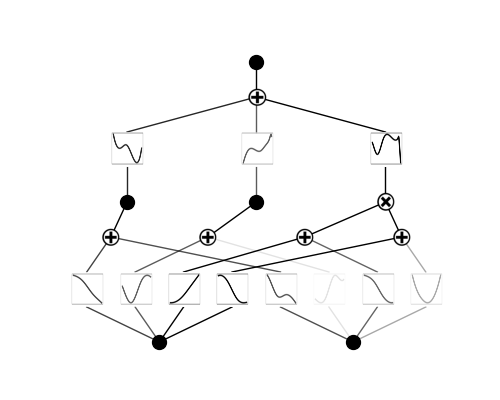

In [102]:
model.plot()

In [103]:
# initialize a more fine-grained KAN with G=10
model = model.refine(10)

saving model version 0.2


Train KAN (grid=10)

In [104]:

model.fit(dataset, opt="Adam", steps=20);

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

| train_loss: 1.78e+00 | test_loss: 1.81e+00 | reg: 1.13e+02 | : 100%|█| 20/20 [00:01<00:00, 11.37it

saving model version 0.3


The loss becomes lower. This is good! Now we can even iteratively making grids finer.

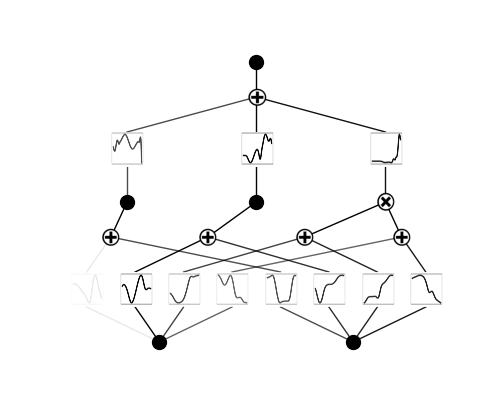

In [105]:
model.plot()

In [45]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

tensor(0.8757, grad_fn=<MeanBackward0>)

In [8]:
grids = [3,10,20,50]
width = [2,[2,1],1]


train_losses = []
test_losses = []
steps = 200
k = 3

for grid in grids:
    if grid == 3:
        model = KAN(width=width, grid=grid, k=k, seed=1, device=device, ckpt_path='./trialmodel')
        model.update_grid_from_samples(data_range)
        lr = 1e-3
    if grid != 3:
        model = model.refine(grid)
        model.update_grid_from_samples(data_range)
        lr = 1e-4
    results = model.fit(dataset, steps=steps, lr=lr)
    train_losses += results['train_loss']
    test_losses += results['test_loss']
    

checkpoint directory created: ./trialmodel
saving model version 0.0


| train_loss: 2.81e-02 | test_loss: 2.80e-02 | reg: 3.01e+01 | : 100%|█| 200/200 [00:52<00:00,  3.79


saving model version 0.1
saving model version 0.2


| train_loss: 2.20e+00 | test_loss: 2.64e+00 | reg: 2.60e+02 | : 100%|█| 200/200 [01:21<00:00,  2.46


saving model version 0.3
saving model version 0.4


| train_loss: 3.13e+00 | test_loss: 4.66e+00 | reg: 9.79e+01 | : 100%|█| 200/200 [02:10<00:00,  1.53


saving model version 0.5
saving model version 0.6


| train_loss: 1.22e+01 | test_loss: 1.47e+01 | reg: 9.41e+01 | : 100%|█| 200/200 [01:38<00:00,  2.02

saving model version 0.7


Training dynamics of losses display staircase structures (loss suddenly drops after grid refinement)

In [182]:
model.saveckpt('./trialmodel')

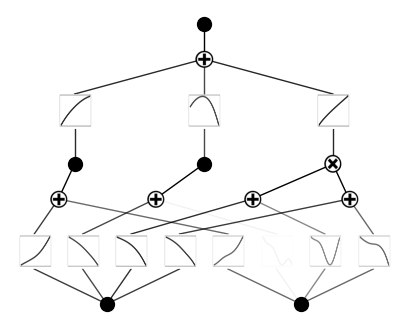

In [3]:
model.plot()

/var/folders/x4/9hvgz2l93r9ft0_yp6wwfdv00000gq/T/ipykernel_59069/1596808475.py:33: UserWarning: The following kwargs were not used by contour: 'linewidth'
  surf = ax.contourf(X, Y, kan_values, levels=num_levels, cmap=cm.coolwarm, vmin=-5.0, vmax=1.0, linewidth=0, antialiased=False)


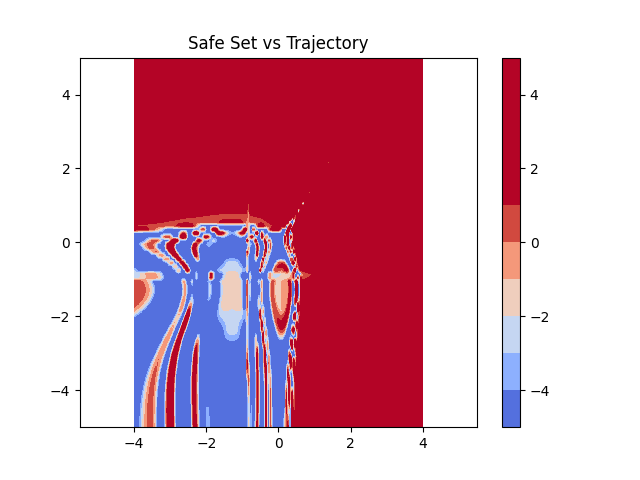

In [9]:
from matplotlib import cm
%matplotlib ipympl
## Plot safe set vs trajectory
#fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
fig, ax = plt.subplots()
## Create 2D grid of states
x = np.linspace(-4.0, 4.0, 200)
y = np.linspace(-10.0, 10.0, 200)
X, Y = np.meshgrid(x, y)
states_grid = np.column_stack((X.flatten(), Y.flatten()))

## Calculate CBF values for each state in the grid
cbf_values = np.linalg.norm(states_grid, axis=1)


# for pair in states_grid:
#     #h_temp = env.h(pair, 0)
#     h_temp = np.linalg.norm(pair)
#     cbf_values.append(h_temp)
# cbf_values = np.array(cbf_values)

states_grid_torch = torch.tensor(states_grid, dtype=torch.float32).to(device)
kan_values = model(states_grid_torch).detach().cpu().numpy()
## sort out all states that are not in the safe set
kan_states_grid = states_grid[np.where(kan_values > 0.0)]

kan_values = kan_values.reshape(X.shape)

kan_values = np.clip(kan_values, -5.0, 5.0)

#ax.contourf(X, Y, cbf_values.reshape(X.shape), cmap='Blues')
num_levels = 10  # Increase this number for finer color gradations
surf = ax.contourf(X, Y, kan_values, levels=num_levels, cmap=cm.coolwarm, vmin=-5.0, vmax=1.0, linewidth=0, antialiased=False)
cbar_ticks = np.linspace(-5.0, 5.0, 21)  # 21 intervals from -5.0 to 5.0


#plt.scatter(kan_states_grid[:, 0], kan_states_grid[:, 1], marker='.', c='red', label='KAN Safe Set', alpha=0.3)
ax.set_xlim(-5.5, 5.5)
ax.set_ylim(-5.0, 5.0)
#ax.set_zlim(-0.1, 0.05)
fig.colorbar(surf)
plt.title('Safe Set vs Trajectory')
plt.show()

In [218]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

tensor(2.8583e-07, grad_fn=<MeanBackward0>)

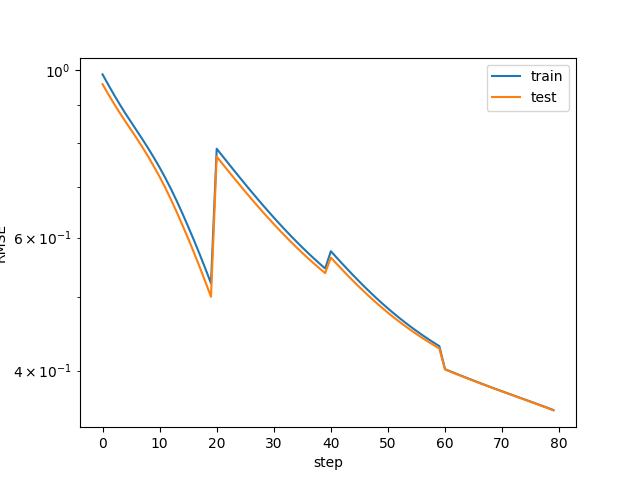

In [167]:
plt.figure()
plt.plot(train_losses)
plt.plot(test_losses)
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

Neural scaling laws (For some reason, this got worse than pykan 0.0. We're still investigating the reason, probably due to the updates of curve2coef)

In [ ]:
x_trial = torch.tensor([[1. % 2*np.pi,1000.0]], device=device)
print(model(x_trial))
print(f(x_trial))

In [ ]:
n_params = 3 * grids
train_vs_G = train_losses[(steps-1)::steps]
test_vs_G = test_losses[(steps-1)::steps]
plt.plot(n_params, train_vs_G, marker="o")
plt.plot(n_params, test_vs_G, marker="o")
plt.plot(n_params, 100*n_params**(-4.), ls="--", color="black")
plt.xscale('log')
plt.yscale('log')
plt.legend(['train', 'test', r'$N^{-4}$'])
plt.xlabel('number of params')
plt.ylabel('RMSE')

In [ ]:
model.plot()

In [ ]:
model.prune(node_th=1e-1, edge_th=0.1)
model.plot()

In [206]:
torch.mean((model(dataset['train_input'])-dataset['train_label'])**2)

tensor(1.5776e-07, grad_fn=<MeanBackward0>)

In [148]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with sin, r2=0.9999989867210388, c=2
fixing (0,0,1) with x, r2=0.8083996176719666, c=1
fixing (0,0,2) with x, r2=0.1464073359966278, c=1
fixing (0,0,3) with x, r2=0.8383316397666931, c=1
fixing (0,1,0) with x^2, r2=0.9999967813491821, c=2
fixing (0,1,1) with x, r2=0.8506585359573364, c=1
fixing (0,1,2) with x, r2=0.1279037445783615, c=1
fixing (0,1,3) with x, r2=0.1631978154182434, c=1
fixing (1,0,0) with x^2, r2=0.9999831914901733, c=2
fixing (1,1,0) with x, r2=1.4870654922560789e-05, c=1
fixing (1,2,0) with x, r2=5.361087684896404e-10, c=1
saving model version 0.6


-0.0014*(0.1868 - 0.e-4*x_1)*(-0.e-4*x_2 - 0.9636) - 2.9402*(0.3651*(1 - 0.0734*x_2)**2 + 0.7654*sin(0.2011*x_1 + 9.7819) + 1)**2 + 3.658

In [184]:
test_point = torch.tensor([0.0, 0.0], device=device, dtype=torch.float32).unsqueeze(0)
model(test_point)

/Users/nmiguel/pykan/kan/MultKAN.py:799: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/Users/nmiguel/pykan/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/Users/nmiguel/pykan/kan/MultKAN.py:810: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/ReduceOps.cpp:1

tensor([[1.0002]], grad_fn=<AddBackward0>)